In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

#import constants

from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
boda2_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)

In [3]:
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)
rounds_0_df = no_controls_df[no_controls_df['round'] == 0].copy().reset_index(drop=True)

methods = ['DHS', 'gs', 'fsp', 'al', 'sa', 'sa_rep', 'hmc', 'fsp_uc', 'al_uc', 'sa_uc']

In [11]:
pd.value_counts(rounds_0_df.loc[rounds_0_df['target_cell'] == rounds_0_df['signal_max_cell']]['method'])

fsp       11900
sa        11829
al        11635
gs        10888
sa_rep     9888
hmc        9305
DHS        7577
sa_uc       300
fsp_uc      300
al_uc       295
Name: method, dtype: int64

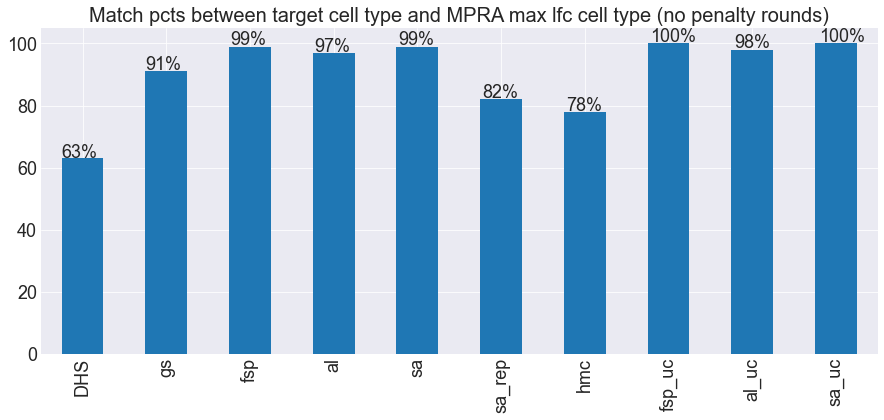

In [12]:
pct_counts_r0 = pd.value_counts(rounds_0_df.loc[rounds_0_df['target_cell'] == rounds_0_df['signal_max_cell']]['method']) \
/ pd.value_counts(rounds_0_df['method']) * 100

temp_dict = dict(pct_counts_r0)
pcts = []
for method in methods:
    pcts.append(round(temp_dict[method]))
    
out_dict = dict(zip(methods, pcts))

with plt.style.context('seaborn-darkgrid'):
    #plt.figure(figsize=(15,5))
    ax = pd.DataFrame.from_dict(out_dict, orient='index').plot.bar(figsize=(15,6), fontsize=18)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height()))+"%", (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=18)

    plt.title('Match pcts between target cell type and MPRA max lfc cell type (no penalty rounds)', fontsize=20)
    plt.legend('')
    plt.show()

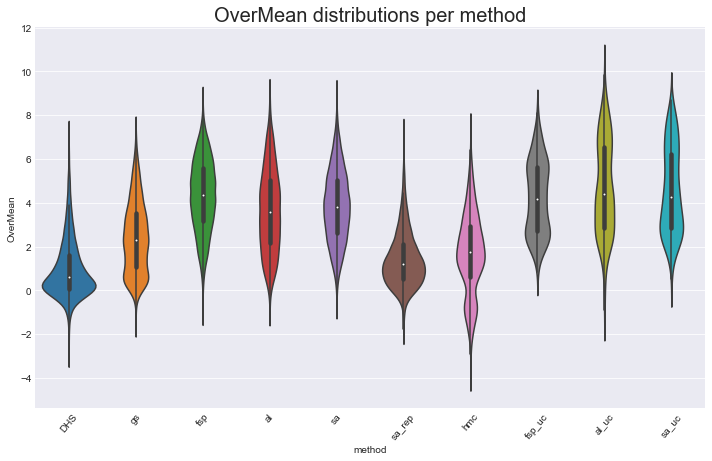

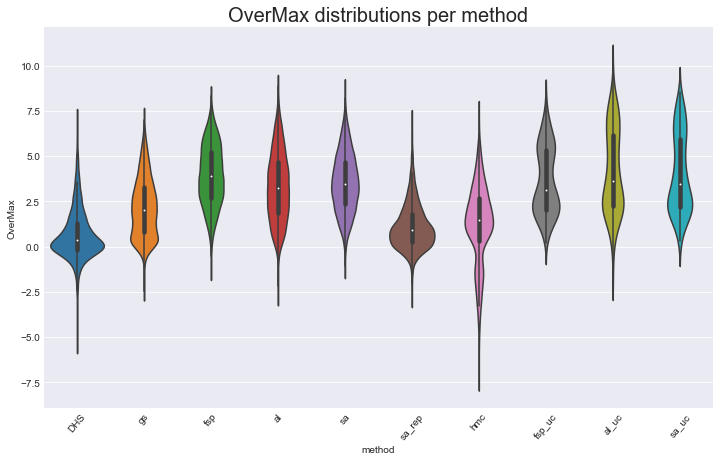

In [13]:
with plt.style.context('seaborn-darkgrid'):   
    plot_df = rounds_0_df
    quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
    
    plt.figure(figsize=(12,7))
    sns.violinplot(data=plot_df[quality_filter], x='method', y='OverMean', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title('OverMean distributions per method', fontsize=20)
    plt.show()
    
    plt.figure(figsize=(12,7))
    sns.violinplot(data=plot_df[quality_filter], x='method', y='OverMax', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title('OverMax distributions per method', fontsize=20)
    plt.show()

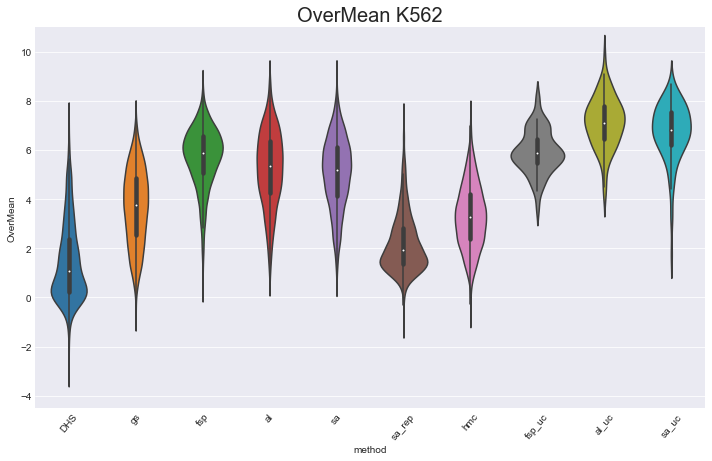

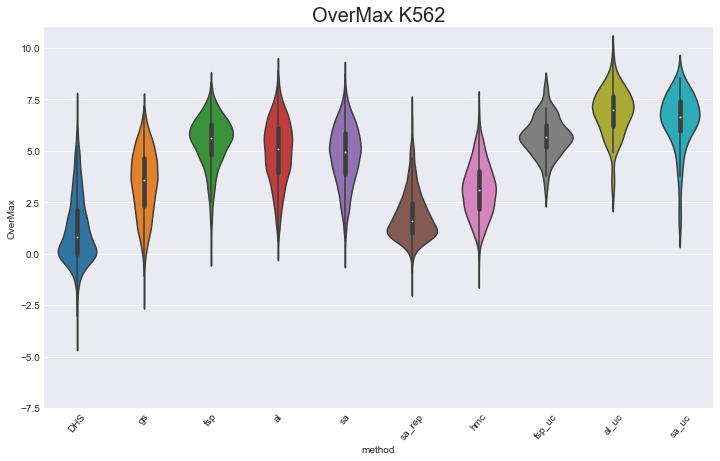

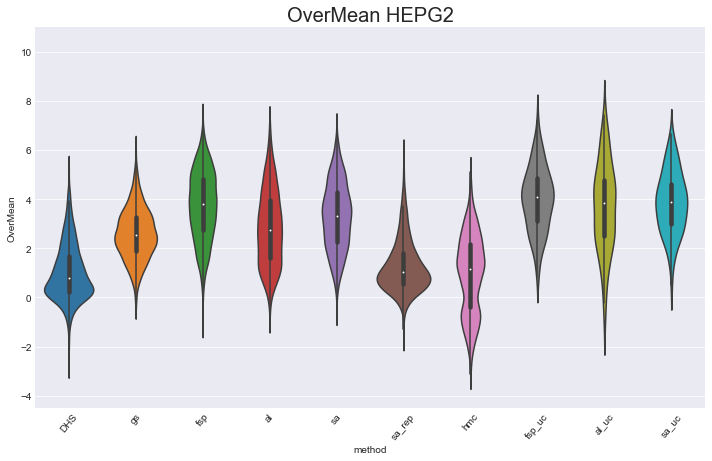

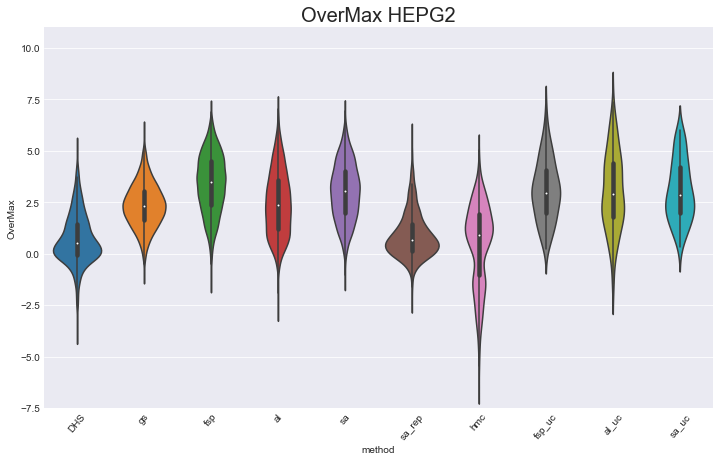

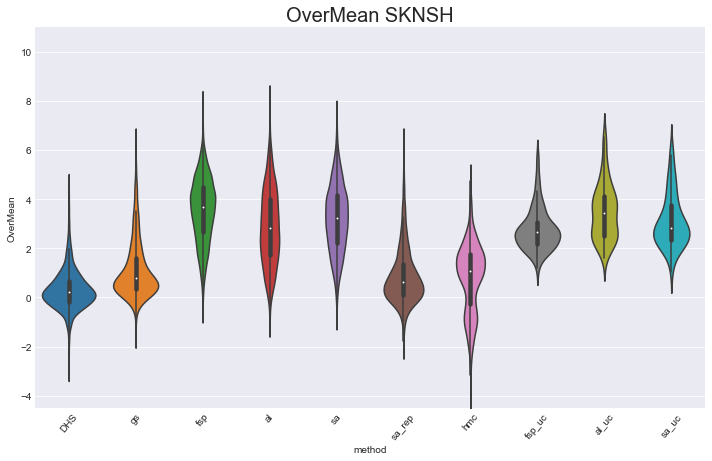

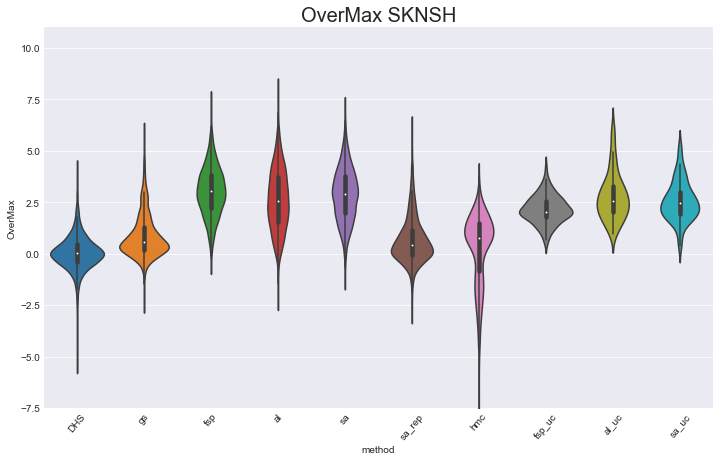

In [14]:
with plt.style.context('seaborn-darkgrid'):   
    for cell_type in ['k562', 'hepg2', 'sknsh']:
        plt.figure(figsize=(12,7))
        plot_df = rounds_0_df[rounds_0_df['target_cell'] == cell_type].copy()
        quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
        sns.violinplot(data=plot_df[quality_filter], x='method', y='OverMean', inner='box', order=methods)
        plt.xticks(rotation=50)
        plt.title(f'OverMean {cell_type.upper()}', fontsize=20)
        plt.ylim(-4.5, 11)
        plt.show()

        plt.figure(figsize=(12,7))
        plot_df = rounds_0_df[rounds_0_df['target_cell'] == cell_type].copy()
        quality_filter = (plot_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
        sns.violinplot(data=plot_df[quality_filter], x='method', y='OverMax', inner='box', order=methods)
        plt.xticks(rotation=50)
        plt.title(f'OverMax {cell_type.upper()}', fontsize=20)
        plt.ylim(-7.5, 11)
        plt.show()

In [15]:
def bending(x, bending_factor=1.0):
    return x - bending_factor * (np.exp(-x) - 1)

rounds_0_df['bent_target_cell_lfc'] = bending(rounds_0_df['target_cell_lfc'])
rounds_0_df['bent_max_non_target_lfc'] = bending(rounds_0_df['max_non_target_lfc'])
rounds_0_df['OverMaxB'] = rounds_0_df['bent_target_cell_lfc'] - rounds_0_df['bent_max_non_target_lfc']

In [16]:
rounds_0_df[['target_cell_lfc', 'max_non_target_lfc', 'bent_target_cell_lfc', 'bent_max_non_target_lfc']]

,target_cell_lfc,max_non_target_lfc,bent_target_cell_lfc,bent_max_non_target_lfc
0,5.287727,2.520816,6.282674,3.440422
1,6.402153,0.609272,7.400495,1.065526
2,4.276053,1.486130,5.262156,2.259883
3,5.615395,2.440630,6.611754,3.353524
4,4.683140,3.765216,5.673890,4.742053
...,...,...,...,...
84895,-0.112114,-0.248105,-0.230754,-0.529700
84896,0.564290,0.005176,0.995526,0.010338
84897,2.428773,2.214319,3.340628,3.105091
84898,1.103688,0.198963,1.772042,0.379383


In [19]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = rounds_0_df[quality_filter]

plot_df.groupby('method')['OverMax'].mean()#, plot_df.groupby('method')['OverMaxB'].mean()

method
DHS       0.676047
al        3.340206
al_uc     4.146408
fsp       3.956384
fsp_uc    3.637091
gs        2.176226
hmc       1.285835
sa        3.546801
sa_rep    1.116876
sa_uc     3.998717
Name: OverMax, dtype: float64

In [20]:
# plot_df = rounds_0_df.copy()

# quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
# plot_df = rounds_0_df[quality_filter]

aver_d = plot_df.groupby('method')['OverMaxB'].mean()
aver = np.array(aver_d)
norm_aver = (aver - aver.mean()) / aver.std()
for idx, key in enumerate(aver_d.keys()):
    spacer = (6 - len(key )) * ' '
    print(f'{key}: {spacer} {round(norm_aver[idx], 2)}')

DHS:     -1.8
al:      0.97
al_uc:   0.69
fsp:     1.11
fsp_uc:  0.26
gs:      -0.59
hmc:     -1.36
sa:      0.95
sa_rep:  -0.79
sa_uc:   0.57


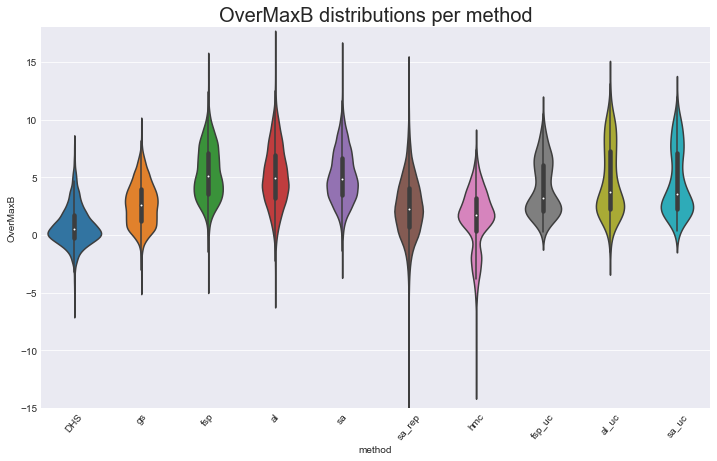

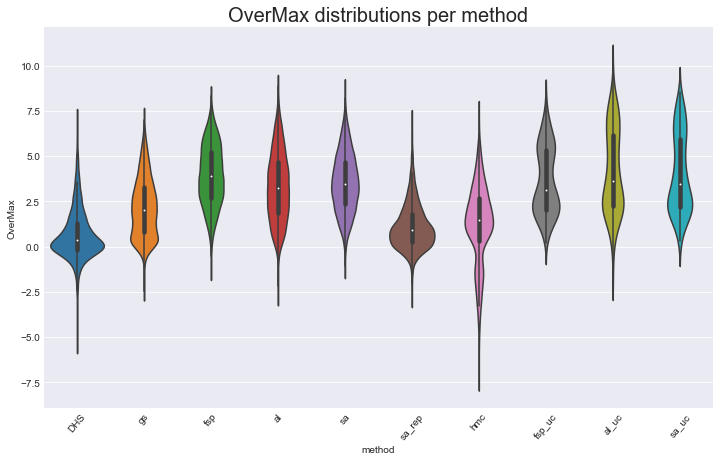

In [21]:
with plt.style.context('seaborn-darkgrid'):   
    plot_df = rounds_0_df
    quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) #& \
                        #(rounds_0_df['OverMax'] > 0.0)
                    #(rounds_0_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']].min(axis=1) >= -0.0)
    
    plt.figure(figsize=(12,7))
    sns.violinplot(data=plot_df[quality_filter], x='method', y='OverMaxB', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title('OverMaxB distributions per method', fontsize=20)
    plt.ylim(-15, 18)
    plt.show()
    
    plt.figure(figsize=(12,7))
    sns.violinplot(data=plot_df[quality_filter], x='method', y='OverMax', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title('OverMax distributions per method', fontsize=20)
    plt.show()

<Figure size 1440x1440 with 0 Axes>

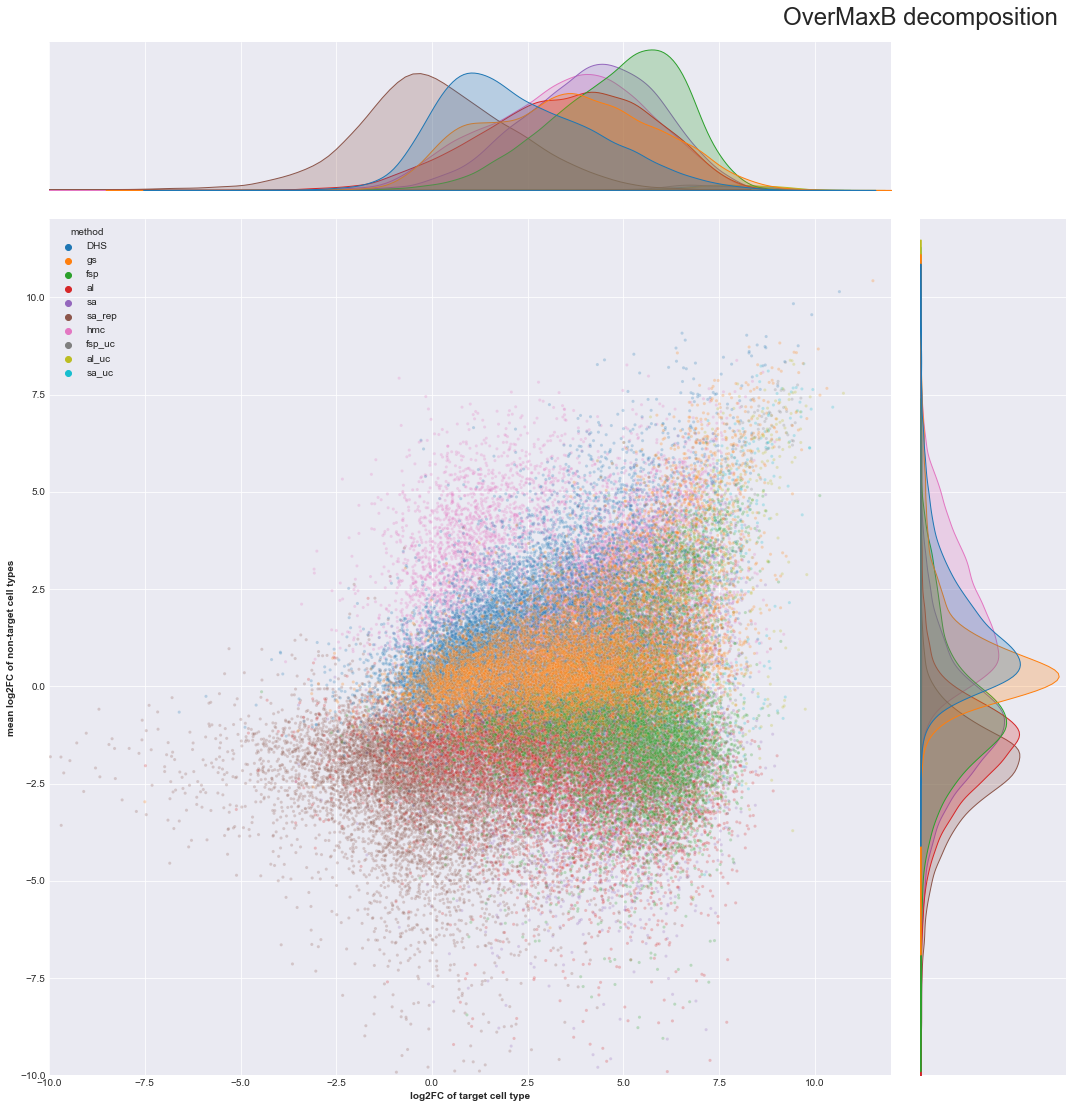

In [22]:
with plt.style.context('seaborn-darkgrid'):   
    plt.figure(figsize=(20,20))
    plot_df = rounds_0_df
    quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

    h = sns.jointplot(data=plot_df[quality_filter], x='bent_target_cell_lfc', y='bent_max_non_target_lfc',
                      hue='method', alpha=0.25, height=15, hue_order=methods, s=10, xlim=(-10, 12), ylim=(-10, 12))
    h.ax_joint.set_xlabel('log2FC of target cell type', fontweight='bold')
    h.ax_joint.set_ylabel('mean log2FC of non-target cell types', fontweight='bold')
    plt.title('OverMaxB decomposition', y=1.22, x=0.0, fontsize = 24)
    plt.show()

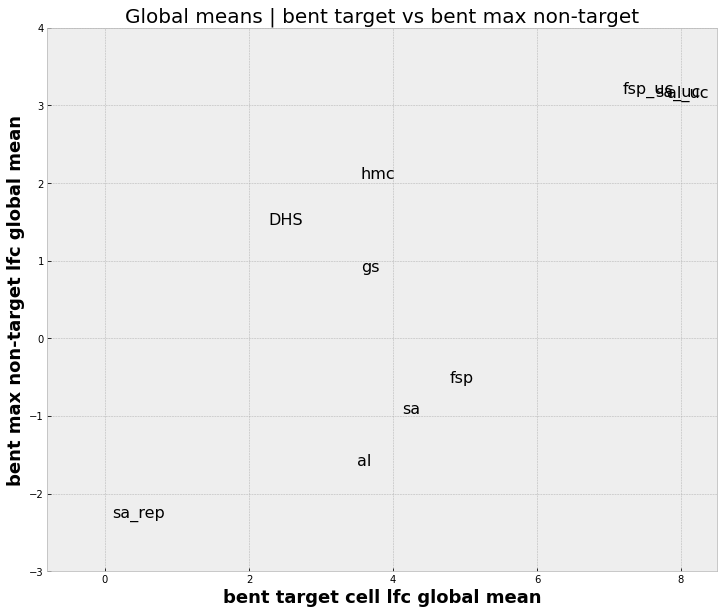

In [23]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
plot_df = rounds_0_df[quality_filter]

y_dict = dict(plot_df.groupby('method')['bent_max_non_target_lfc'].mean())
x_dict = dict(plot_df.groupby('method')['bent_target_cell_lfc'].mean())

with plt.style.context('bmh'):
    plt.figure(figsize=(12,10))
    x_max, y_max = max(x_dict.values()), max(y_dict.values())
    x_min, y_min = min(x_dict.values()), min(y_dict.values())

    for method in methods:
        if method=='genome_scan': text = 'gs'
        else: text = method
        plt.text(x_dict[method], y_dict[method], text, fontsize=16)

#     plt.xlim(x_min - 1, x_max + 1)
#     plt.ylim(y_min - 1, y_max + 1)
    plt.xlim(-0.8, 8.5)
    plt.ylim(-3, 4)
    plt.xlabel('bent target cell lfc global mean', fontweight='bold', fontsize=18)
    plt.ylabel('bent max non-target lfc global mean', fontweight='bold', fontsize=18)
    plt.title('Global means | bent target vs bent max non-target', fontsize=20)
    plt.show()

In [24]:
# rounds_0_df['OverMax_norm'] = (rounds_0_df['OverMax'] - rounds_0_df['OverMax'].mean()) / rounds_0_df['OverMax'].std()
# rounds_0_df['OverMaxB_norm'] = (rounds_0_df['OverMaxB'] - rounds_0_df['OverMaxB'].mean()) / rounds_0_df['OverMaxB'].std()
# rounds_0_df['OverMean_norm'] = (rounds_0_df['OverMean'] - rounds_0_df['OverMean'].mean()) / rounds_0_df['OverMean'].std()

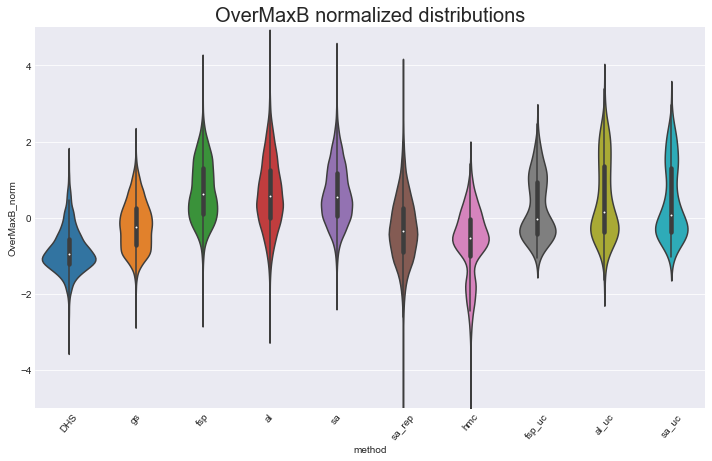

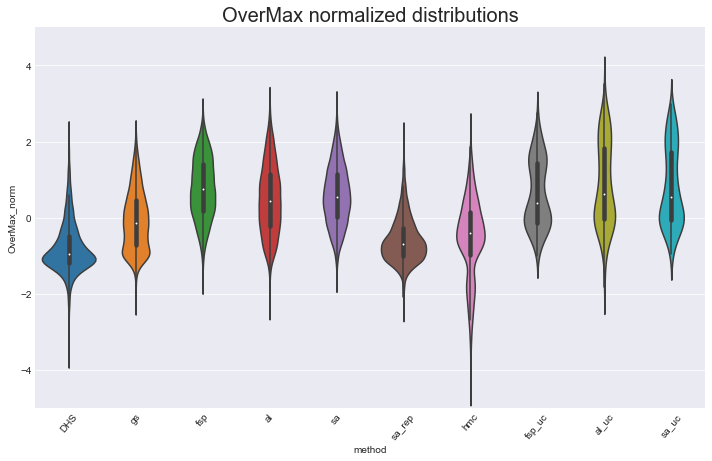

In [25]:
with plt.style.context('seaborn-darkgrid'):   
    #plot_df = rounds_0_df
    quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) #& \
                        #(rounds_0_df['OverMax'] > 0.0)
                    #(rounds_0_df[['K562_signal', 'HepG2_signal', 'SKNSH_signal']].min(axis=1) >= -0.0)
    plot_df = rounds_0_df[quality_filter].copy()
    plot_df['OverMax_norm'] = (plot_df['OverMax'] - plot_df['OverMax'].mean()) / plot_df['OverMax'].std()
    plot_df['OverMaxB_norm'] = (plot_df['OverMaxB'] - plot_df['OverMaxB'].mean()) / plot_df['OverMaxB'].std()
    
    plt.figure(figsize=(12,7))
    sns.violinplot(data=plot_df, x='method', y='OverMaxB_norm', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title('OverMaxB normalized distributions', fontsize=20)
    plt.ylim(-5, 5)
    plt.show()
    
    plt.figure(figsize=(12,7))
    sns.violinplot(data=plot_df, x='method', y='OverMax_norm', inner='box', order=methods)
    plt.xticks(rotation=50)
    plt.title('OverMax normalized distributions', fontsize=20)
    plt.ylim(-5, 5)
    plt.show()

In [26]:
plot_df

,ID,sequence,project,method,round,K562_signal,HepG2_signal,SKNSH_signal,K562_lfcSE,HepG2_lfcSE,SKNSH_lfcSE,K562_ctrl_mean,HepG2_ctrl_mean,SKNSH_ctrl_mean,K562_exp_mean,HepG2_exp_mean,SKNSH_exp_mean,K562_pred,HepG2_pred,SKNSH_pred,K562_pred_aggreg,HepG2_pred_aggreg,SKNSH_pred_aggreg,pred_max_cell,signal_max_cell,target_cell,target_cell_lfc,max_non_target_cell,max_non_target_lfc,min_non_target_cell,min_non_target_lfc,mean_non_target_lfc,OverMean,OverMax,contrib_K562,contrib_HepG2,contrib_SKNSH,bent_target_cell_lfc,bent_max_non_target_lfc,OverMaxB,OverMax_norm,OverMaxB_norm
0,20211210_200256__612928__5::fsp_uc__hepg2__0,CAATCTGTTCCCACCATCAGGTTACTGGTTAATCATTAACCAGGGC...,BODA:hepg2,fsp_uc,0,2.520816,5.287727,0.605723,0.316205,0.309186,0.208455,450.265971,450.265971,450.265971,2584.983789,17588.102886,684.911429,-0.055265,14.231705,0.080212,0.140002,14.336414,0.227027,hepg2,hepg2,hepg2,5.287727,k562,2.520816,sknsh,0.605723,1.563270,3.724457,2.766911,[ 2.21043210e-02 4.64022532e-03 1.00994157e-...,[ 1.1422859e-01 2.5873125e-01 2.2765625e-01 ...,[ 0.004331928 0.07783466 0.06386908 ...,6.282674,3.440422,2.842252,0.210078,-0.158720
1,20211210_200256__612928__12::fsp_uc__hepg2__0,GGAGCTCTTTCAATGCCAGGCAGGCCCGTGGTGCAGTAAAGGCCTG...,BODA:hepg2,fsp_uc,0,0.609272,6.402153,0.271218,0.285060,0.301327,0.340279,186.544915,186.544915,186.544915,285.193149,15770.229152,224.886662,-0.019169,19.914394,0.777519,-0.011601,18.561650,0.767500,hepg2,hepg2,hepg2,6.402153,k562,0.609272,sknsh,0.271218,0.440245,5.961907,5.792880,[-0.00856874 -0.012687626 0.03335264 ...,[-2.79185679e-02 2.33078538e-03 2.57074833e-...,[-0.017693618 -0.015454747 0.01019545 ...,7.400495,1.065526,6.334969,1.659632,1.038493
2,20211210_200256__612928__47::fsp_uc__hepg2__0,GGTTCAAAGTCCAGTCACAGTCCAAAGTCCACTCTTTGTCCAAGAG...,BODA:hepg2,fsp_uc,0,1.486130,4.276053,-0.578350,0.271874,0.366801,0.241865,914.631030,914.631030,914.631030,2563.392133,17720.211245,612.217031,-0.146010,12.227689,-0.400996,-0.034775,10.825762,-0.337030,hepg2,hepg2,hepg2,4.276053,k562,1.486130,sknsh,-0.578350,0.453890,3.822163,2.789924,[-5.54974526e-02 -2.83153541e-02 -1.36791170e-...,[ 0.041962117 0.2561933 0.058943637 0....,[-4.9518015e-02 -2.5722878e-02 -4.6560772e-02 ...,5.262156,2.259883,3.002273,0.221102,-0.103869
3,20211210_200256__612928__69::fsp_uc__hepg2__0,TAATAGTATGTCATCGTAATATGCGGACTTTGAACCGTGTACCAGG...,BODA:hepg2,fsp_uc,0,2.440630,5.615395,1.063669,0.219559,0.313984,0.230603,141.922642,141.922642,141.922642,771.612103,6958.102060,296.614753,1.216181,18.812680,1.589409,1.416824,17.606884,1.713512,hepg2,hepg2,hepg2,5.615395,k562,2.440630,sknsh,1.063669,1.752150,3.863246,3.174765,[ 0.16365409 0.0731409 0.114835456 ...,[ 1.40735984e-01 1.30295590e-01 1.24457464e-...,[ 1.11630686e-01 9.51312631e-02 1.00722231e-...,6.611754,3.353524,3.258230,0.405456,-0.016134
5,20211210_200256__612928__100::fsp_uc__hepg2__0,GCCAAGGTAGTCACTTCGTACGCGGACTTTGAACCCTTGTTTACAC...,BODA:hepg2,fsp_uc,0,2.413817,5.918777,-0.833164,0.318202,0.329277,0.251614,440.995058,440.995058,440.995058,2351.849477,26680.694935,247.568437,-0.024094,18.570503,-0.690376,0.032686,16.117437,-0.570443,hepg2,hepg2,hepg2,5.918777,k562,2.413817,sknsh,-0.833164,0.790326,5.128451,3.504960,[-6.68218778e-03 -9.31845233e-03 -2.74277255e-...,[-5.14521338e-02 -4.86520790e-02 -2.01671403e-...,[-0.009068921 -0.044414442 -0.004151267 ...,6.916089,3.324344,3.591745,0.563632,0.098187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84895,chr4:49653500-49653700,AATGGAATGGAATGGAATGGAAATGAATGGAATGGAATAACATGCA...,BODA:genomic,gs,0,-0.358920,-0.248105,-0.112114,0.247093,0.266864,0.191480,519.182294,519.182294,519.182294,401.638510,437.120670,480.173619,-0.259550,-0.350268,1.980883,-0.238864,-0.339671,1.852794,sknsh,sknsh,sknsh,-0.112114,hepg2,-0.248105,k562,-0.358920,-0.303513,0.191399,0.135991,[ 1.57648958e-02 2.40496714e-02 1.48133254e-...,[ 0.040955

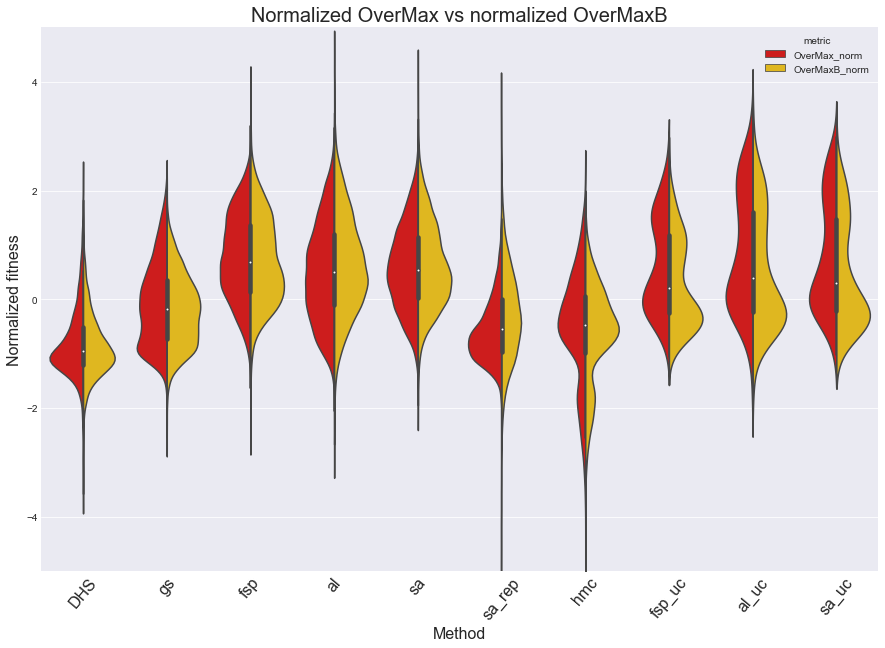

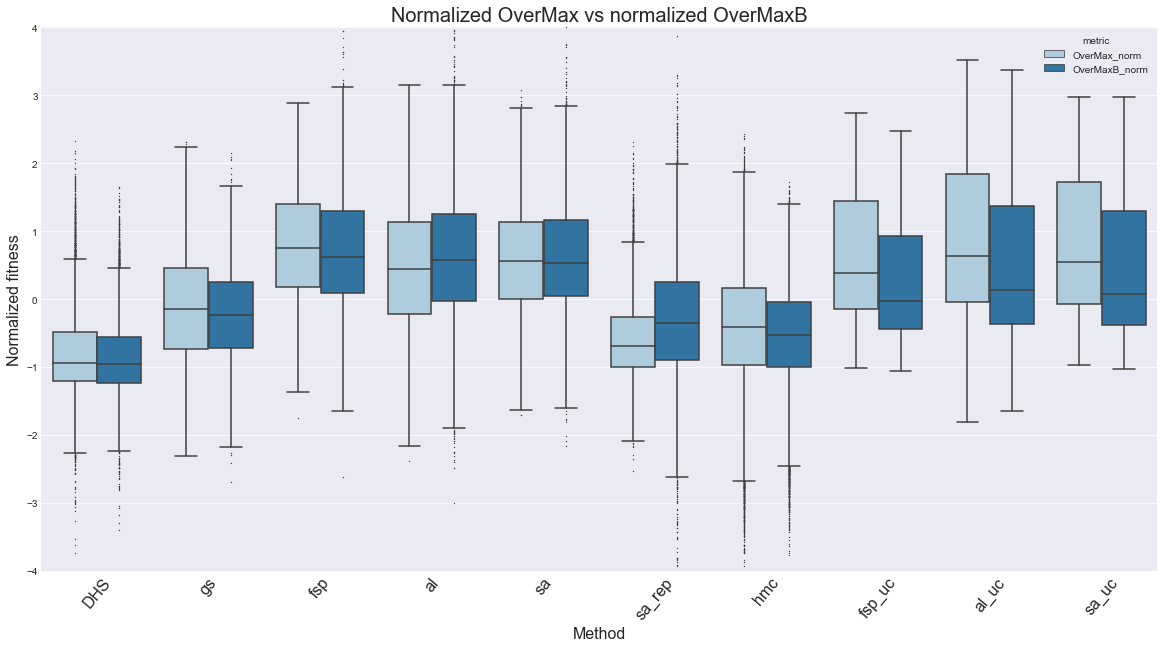

In [27]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df[quality_filter].copy().reset_index(drop=True)

plot_df['OverMax_norm'] = (plot_df['OverMax'] - plot_df['OverMax'].mean()) / plot_df['OverMax'].std()
plot_df['OverMaxB_norm'] = (plot_df['OverMaxB'] - plot_df['OverMaxB'].mean()) / plot_df['OverMaxB'].std()
plot_df['OverMean_norm'] = (plot_df['OverMean'] - plot_df['OverMean'].mean()) / plot_df['OverMean'].std()
    
method_colum = 2 * plot_df['method'].tolist()
fitness_column = plot_df['OverMax_norm'].tolist() + plot_df['OverMaxB_norm'].tolist()
metric_column = len(plot_df) * ['OverMax_norm'] + len(plot_df) * ['OverMaxB_norm']

temp_df = pd.DataFrame({'method': method_colum, 'fitness': fitness_column, 'metric': metric_column})

with plt.style.context('seaborn-darkgrid'): 
    plt.figure(figsize=(15,10))
    sns.violinplot(data=temp_df, x='method', y='fitness', hue='metric', split=True, order=methods, trim=True, palette='hot')
    plt.xticks(rotation=50, fontsize=16)
    plt.xlabel('Method', fontsize=16)
    plt.ylabel('Normalized fitness', fontsize=16)
    plt.title('Normalized OverMax vs normalized OverMaxB', fontsize=20)
    plt.ylim(-5, 5)
    plt.show()
    
with plt.style.context('seaborn-darkgrid'): 
    plt.figure(figsize=(20,10))
    sns.boxplot(data=temp_df, x='method', y='fitness', hue='metric', order=methods, palette='Paired', fliersize=0.5)
    plt.xticks(rotation=50, fontsize=16)
    plt.xlabel('Method', fontsize=16)
    plt.ylabel('Normalized fitness', fontsize=16)
    plt.title('Normalized OverMax vs normalized OverMaxB', fontsize=20)
    plt.ylim(-4, 4)
    plt.show()

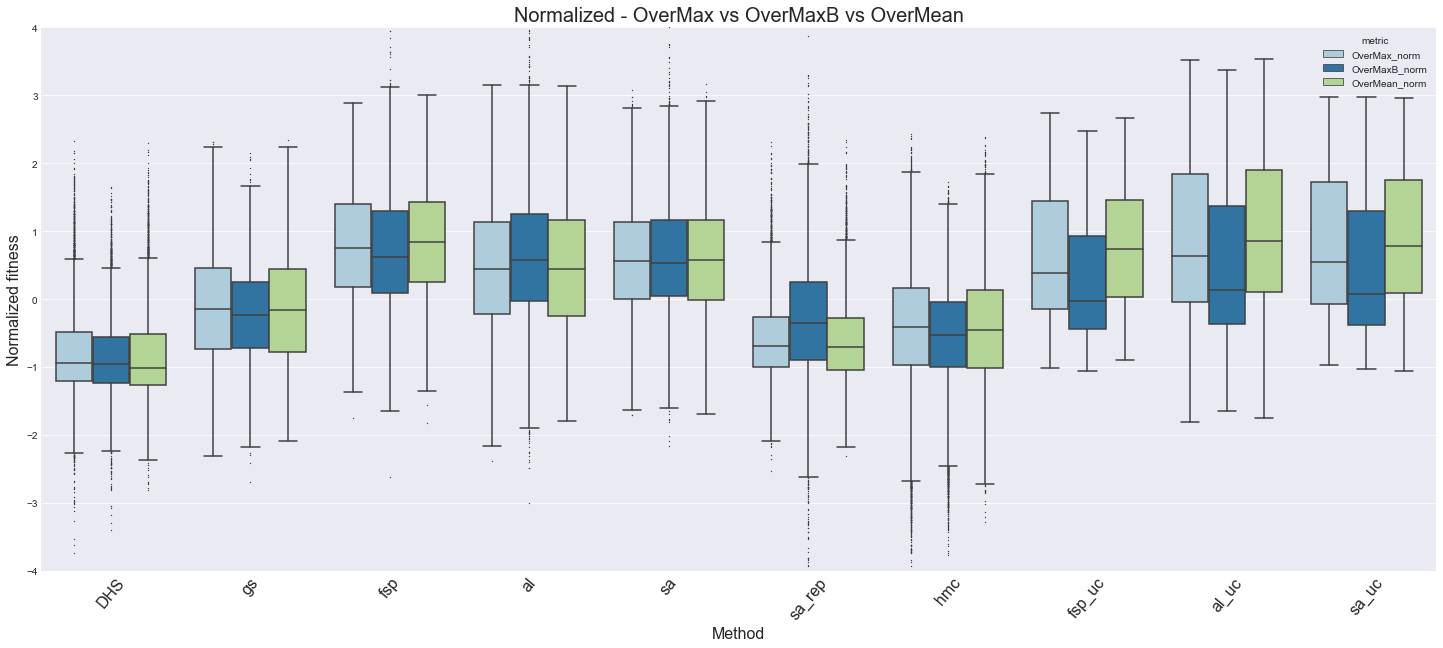

In [28]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df[quality_filter].copy().reset_index(drop=True)

plot_df['OverMax_norm'] = (plot_df['OverMax'] - plot_df['OverMax'].mean()) / plot_df['OverMax'].std()
plot_df['OverMaxB_norm'] = (plot_df['OverMaxB'] - plot_df['OverMaxB'].mean()) / plot_df['OverMaxB'].std()
plot_df['OverMean_norm'] = (plot_df['OverMean'] - plot_df['OverMean'].mean()) / plot_df['OverMean'].std()
    
method_colum = 3 * plot_df['method'].tolist()
fitness_column = plot_df['OverMax_norm'].tolist() + plot_df['OverMaxB_norm'].tolist() + plot_df['OverMean_norm'].tolist()
metric_column = len(plot_df) * ['OverMax_norm'] + len(plot_df) * ['OverMaxB_norm'] + len(plot_df) * ['OverMean_norm']
target_cell_colum = 3 * plot_df['target_cell'].tolist()

temp_df = pd.DataFrame({'method': method_colum, 'fitness': fitness_column, 'metric': metric_column, 'target_cell':target_cell_colum})

with plt.style.context('seaborn-darkgrid'): 
    plt.figure(figsize=(25,10))
    sns.boxplot(data=temp_df, x='method', y='fitness', hue='metric', order=methods, palette='Paired', fliersize=0.5)
    plt.xticks(rotation=50, fontsize=16)
    plt.xlabel('Method', fontsize=16)
    plt.ylabel('Normalized fitness', fontsize=16)
    plt.title('Normalized - OverMax vs OverMaxB vs OverMean', fontsize=20)
    plt.ylim(-4, 4)
    plt.show()

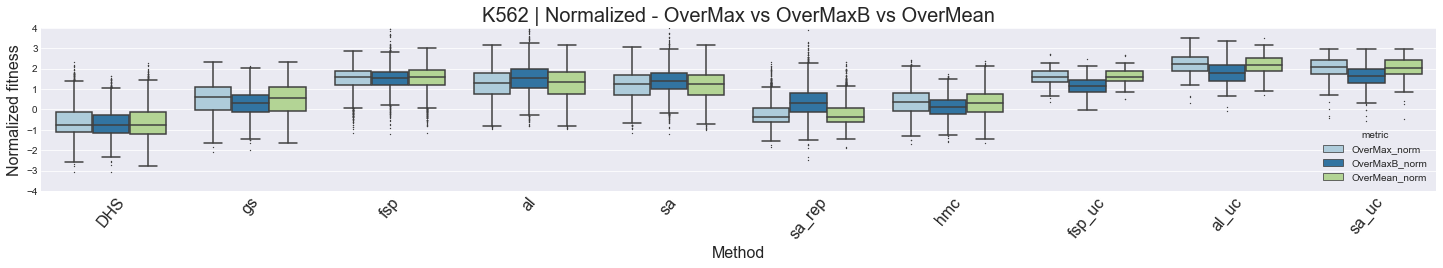

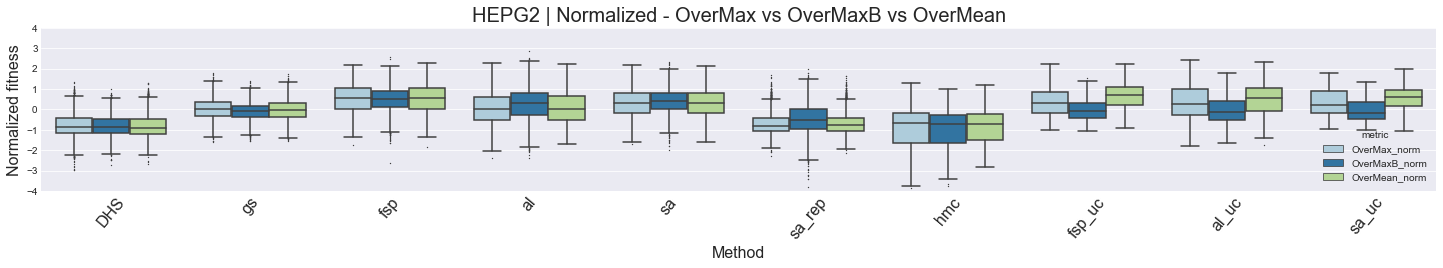

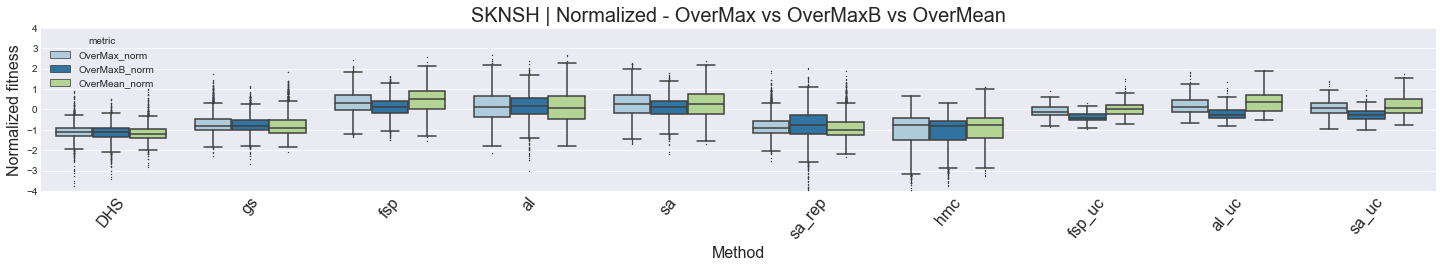

In [30]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df[quality_filter].copy().reset_index(drop=True)

plot_df['OverMax_norm'] = (plot_df['OverMax'] - plot_df['OverMax'].mean()) / plot_df['OverMax'].std()
plot_df['OverMaxB_norm'] = (plot_df['OverMaxB'] - plot_df['OverMaxB'].mean()) / plot_df['OverMaxB'].std()
plot_df['OverMean_norm'] = (plot_df['OverMean'] - plot_df['OverMean'].mean()) / plot_df['OverMean'].std()
    
method_colum = 3 * plot_df['method'].tolist()
fitness_column = plot_df['OverMax_norm'].tolist() + plot_df['OverMaxB_norm'].tolist() + plot_df['OverMean_norm'].tolist()
metric_column = len(plot_df) * ['OverMax_norm'] + len(plot_df) * ['OverMaxB_norm'] + len(plot_df) * ['OverMean_norm']
target_cell_colum = 3 * plot_df['target_cell'].tolist()

temp_df = pd.DataFrame({'method': method_colum, 'fitness': fitness_column, 'metric': metric_column, 'target_cell':target_cell_colum})

for cell_type in ['k562', 'hepg2', 'sknsh']:
    temp_df2 = temp_df[temp_df['target_cell'] == cell_type]
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(25,3))
        sns.boxplot(data=temp_df2, x='method', y='fitness', hue='metric', order=methods, palette='Paired', fliersize=0.5)
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('Normalized fitness', fontsize=16)
        plt.title(f'{cell_type.upper()} | Normalized - OverMax vs OverMaxB vs OverMean', fontsize=20)
        plt.ylim(-4, 4)
        plt.show()


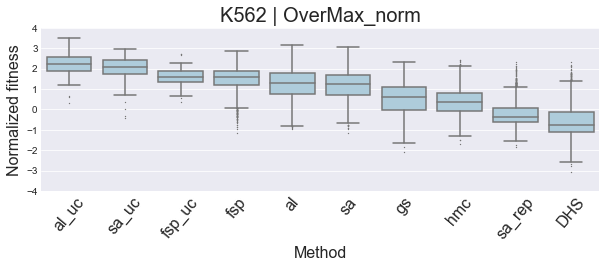

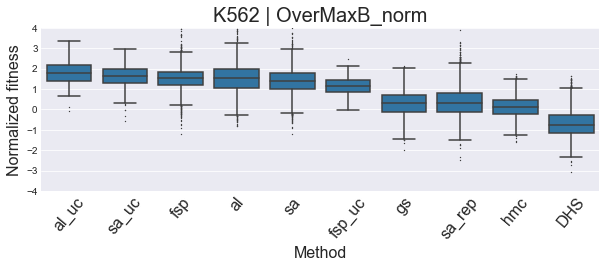

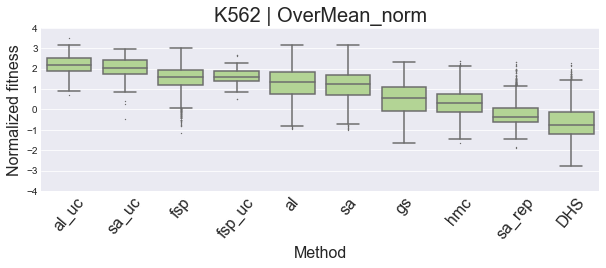

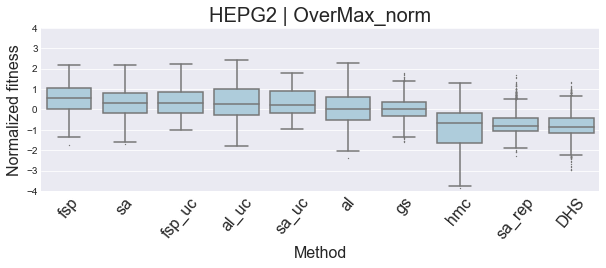

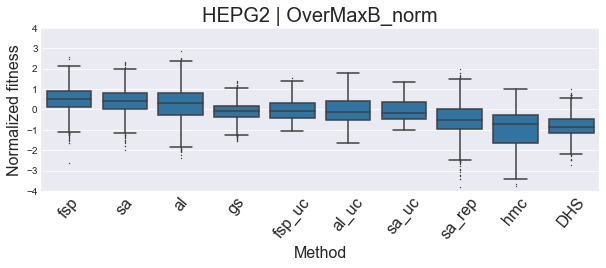

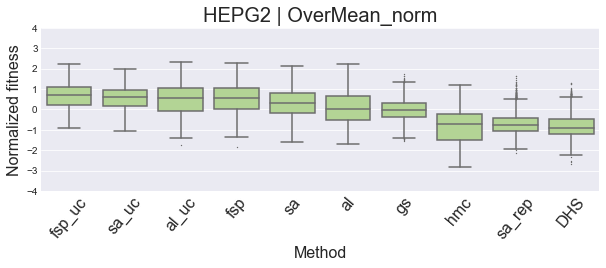

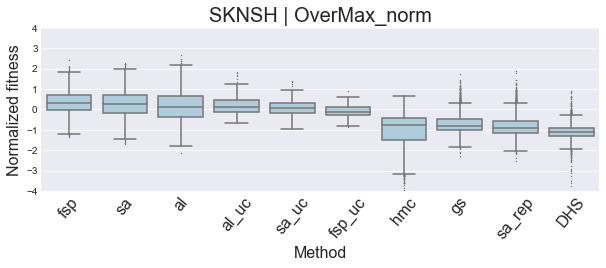

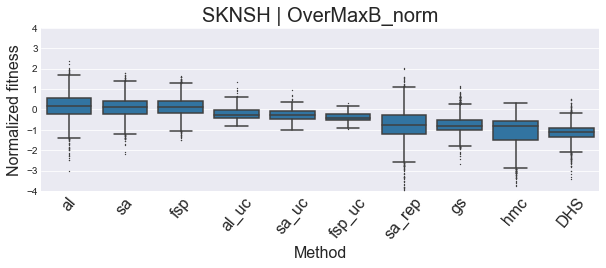

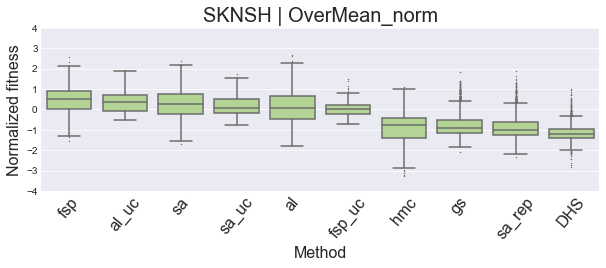

In [31]:
cmap = plt.cm.get_cmap('Paired')

for cell_type in ['k562', 'hepg2', 'sknsh']:
    color_idx = 0
    for metric in ['OverMax_norm', 'OverMaxB_norm', 'OverMean_norm']:       
        temp_df2 = temp_df[(temp_df['target_cell'] == cell_type) & (temp_df['metric'] == metric)]
        temp_order = temp_df2.groupby(by=['method'])['fitness'].median().sort_values(ascending=False).index      
        with plt.style.context('seaborn-darkgrid'): 
            plt.figure(figsize=(10,3))
            sns.boxplot(data=temp_df2, x='method', y='fitness', order=temp_order, fliersize=0.5, color=cmap(color_idx))
            plt.xticks(rotation=50, fontsize=16)
            plt.xlabel('Method', fontsize=16)
            plt.ylabel('Normalized fitness', fontsize=16)
            plt.title(f'{cell_type.upper()} | {metric}', fontsize=20)
            plt.ylim(-4, 4)
            plt.show()
        color_idx += 1

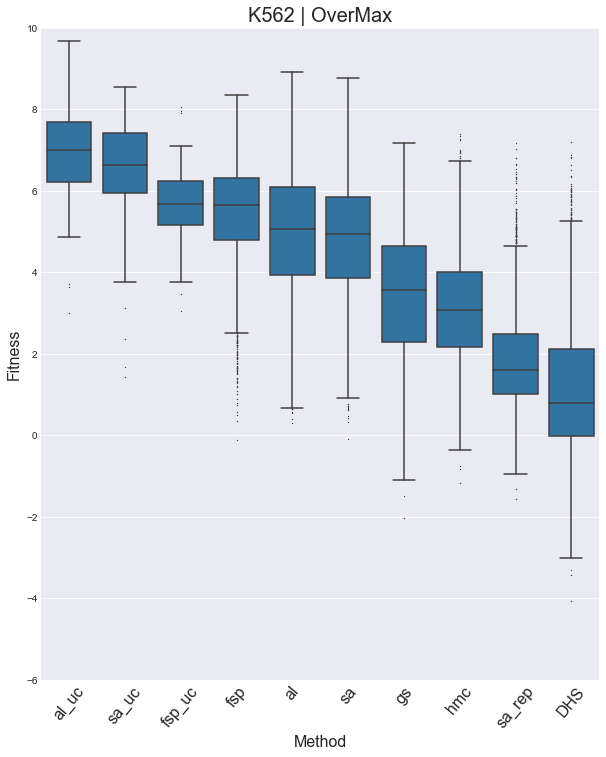

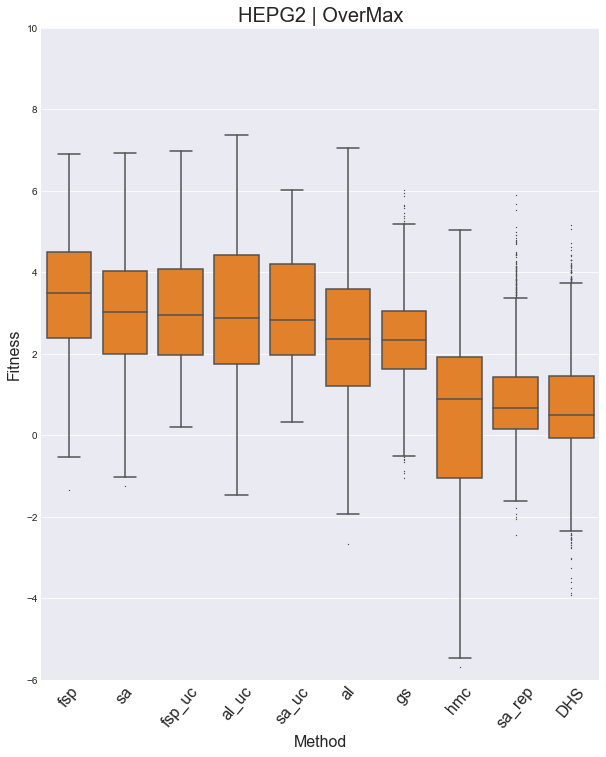

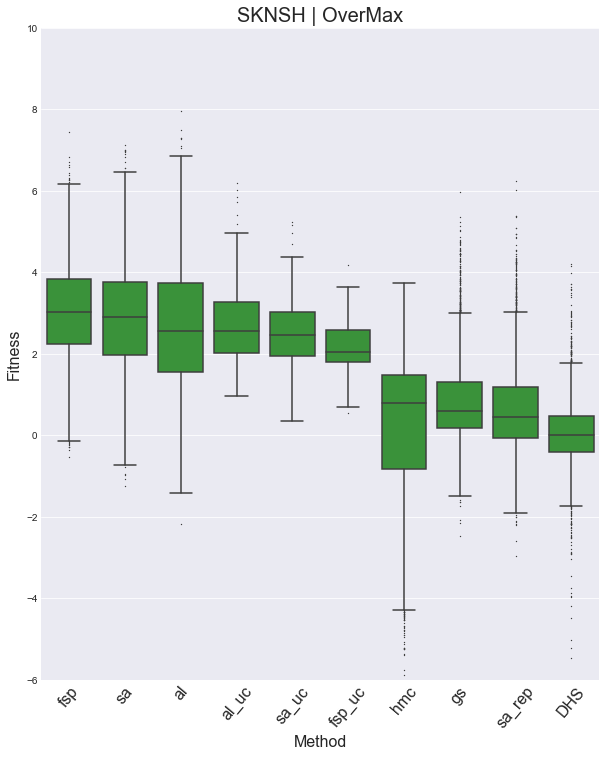

In [32]:
quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df[quality_filter].copy().reset_index(drop=True)

# plot_df['OverMax_norm'] = (plot_df['OverMax'] - plot_df['OverMax'].mean()) / plot_df['OverMax'].std()
# plot_df['OverMaxB_norm'] = (plot_df['OverMaxB'] - plot_df['OverMaxB'].mean()) / plot_df['OverMaxB'].std()
# plot_df['OverMean_norm'] = (plot_df['OverMean'] - plot_df['OverMean'].mean()) / plot_df['OverMean'].std()
    
# method_colum = 3 * plot_df['method'].tolist()
# fitness_column = plot_df['OverMax_norm'].tolist() + plot_df['OverMaxB_norm'].tolist() + plot_df['OverMean_norm'].tolist()
# metric_column = len(plot_df) * ['OverMax_norm'] + len(plot_df) * ['OverMaxB_norm'] + len(plot_df) * ['OverMean_norm']
# target_cell_colum = 3 * plot_df['target_cell'].tolist()

#temp_df = pd.DataFrame({'method': method_colum, 'fitness': fitness_column, 'metric': metric_column, 'target_cell':target_cell_colum})

for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    temp_order = temp_df2.groupby(by=['method'])['OverMax'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(10,12))
        sns.boxplot(data=temp_df2, x='method', y='OverMax', order=temp_order, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('Fitness', fontsize=16)
        plt.title(f'{cell_type.upper()} | OverMax', fontsize=20)
        plt.ylim(-6, 10)
        plt.show()

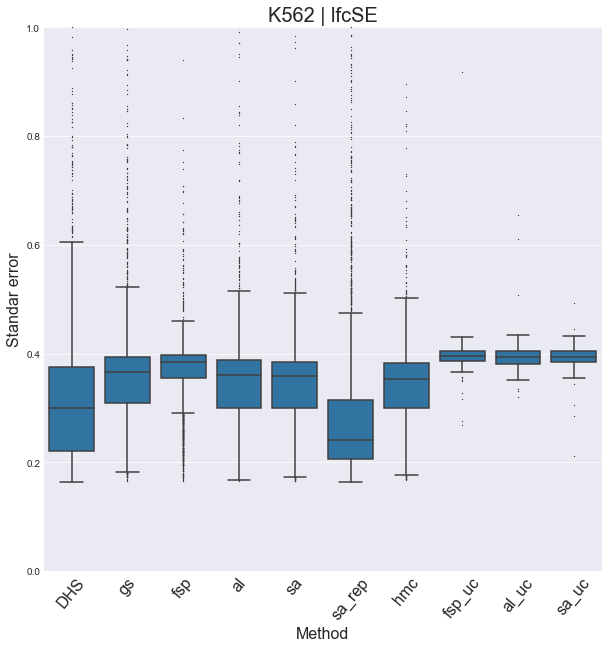

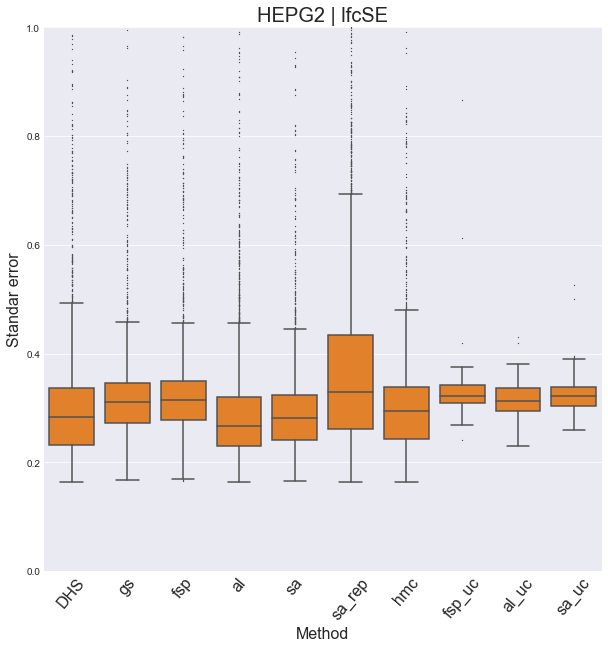

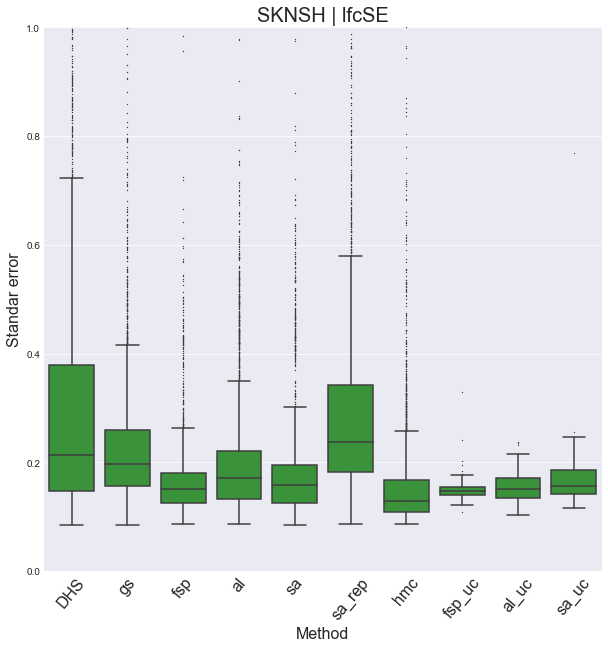

In [33]:
#quality_filter = (rounds_0_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0) 
plot_df = rounds_0_df#[quality_filter].copy().reset_index(drop=True)

lfcSE_names = ['K562', 'HepG2', 'SKNSH']
for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    #temp_order = temp_df2.groupby(by=['method'])['OverMax'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(10,10))
        sns.boxplot(data=temp_df2, x='method', y=f'{lfcSE_names[color_idx]}_lfcSE', order=methods, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('Standar error', fontsize=16)
        plt.title(f'{cell_type.upper()} | lfcSE', fontsize=20)
        plt.ylim(0, 1)
        plt.show()

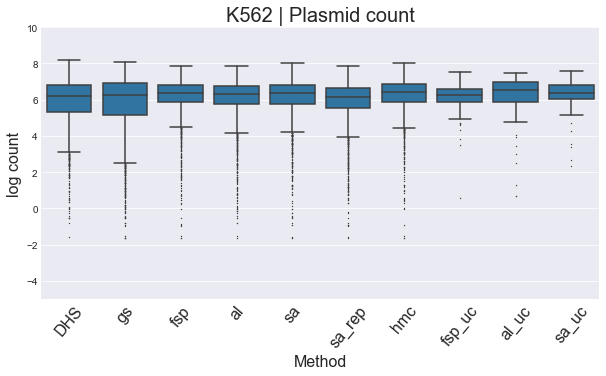

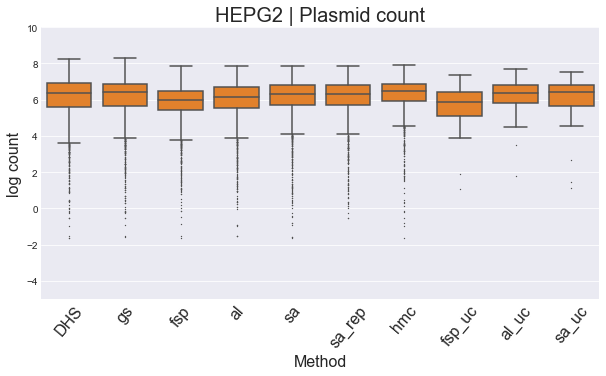

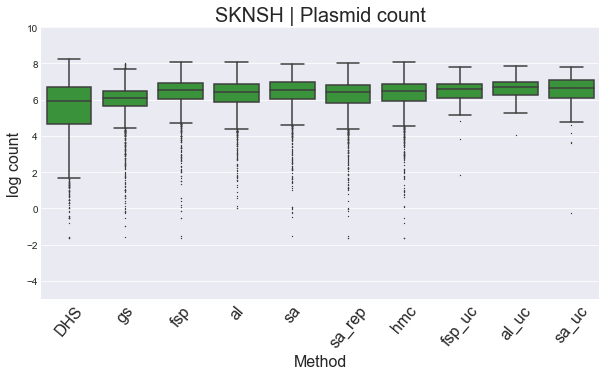

In [38]:
plot_df = rounds_0_df#[quality_filter].copy().reset_index(drop=True)

lfcSE_names = ['K562', 'HepG2', 'SKNSH']
for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    #temp_order = temp_df2.groupby(by=['method'])['OverMax'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(10,5))
        sns.boxplot(data=temp_df2, x='method', y=np.log(temp_df2[f'{lfcSE_names[color_idx]}_ctrl_mean'] +1e-6),
                    order=methods, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('log count', fontsize=16)
        plt.title(f'{cell_type.upper()} | Plasmid count', fontsize=20)
        plt.ylim(-5, 10)
        plt.show()

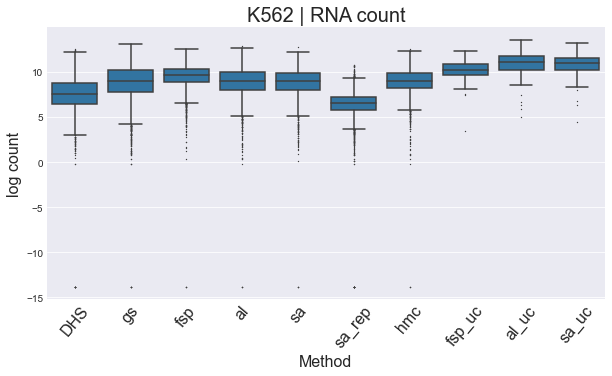

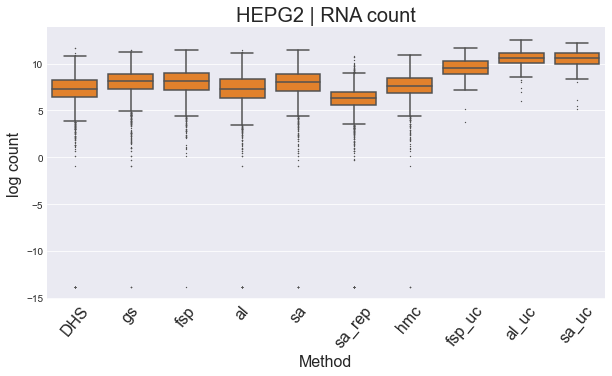

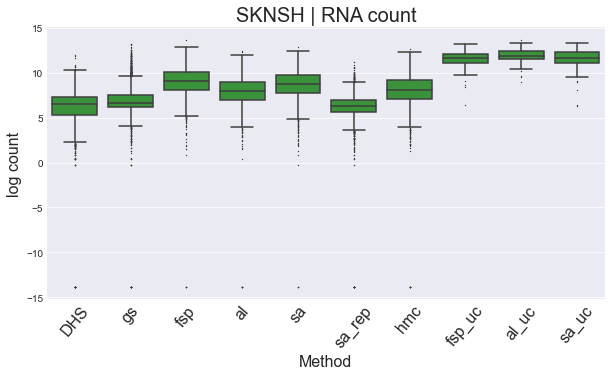

In [40]:
plot_df = rounds_0_df#[quality_filter].copy().reset_index(drop=True)

lfcSE_names = ['K562', 'HepG2', 'SKNSH']
for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    #temp_order = temp_df2.groupby(by=['method'])['OverMax'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(10,5))
        sns.boxplot(data=temp_df2, x='method', y=np.log(temp_df2[f'{lfcSE_names[color_idx]}_exp_mean'] + 1e-6),
                    order=methods, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('log count', fontsize=16)
        plt.title(f'{cell_type.upper()} | RNA count', fontsize=20)
        #plt.ylim(0, 1)
        plt.show()

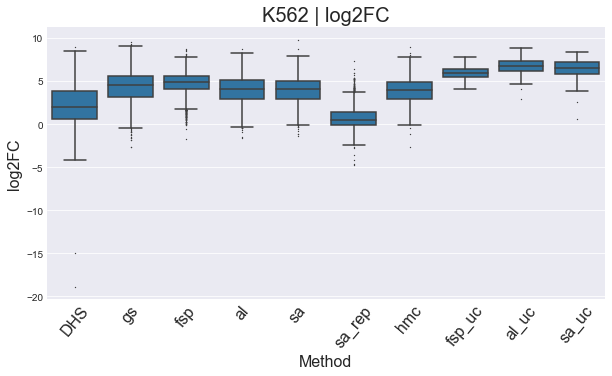

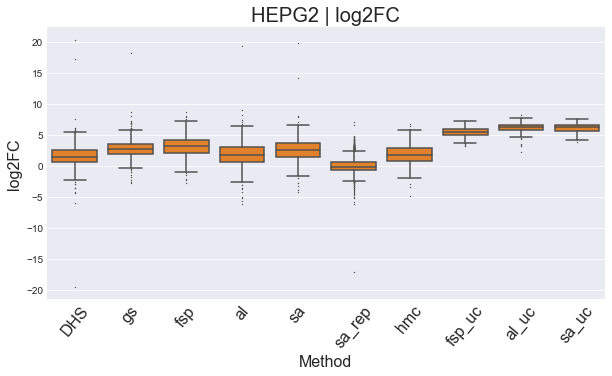

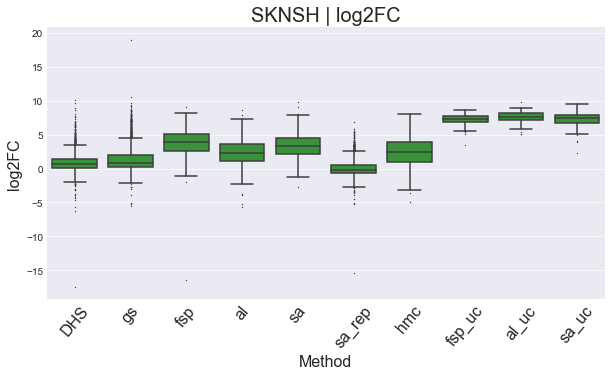

In [378]:
plot_df = rounds_0_df#[quality_filter].copy().reset_index(drop=True)

lfcSE_names = ['K562', 'HepG2', 'SKNSH']
for color_idx, cell_type in enumerate(['k562', 'hepg2', 'sknsh']):  
    temp_df2 = plot_df[(plot_df['target_cell'] == cell_type)].copy()
    #temp_order = temp_df2.groupby(by=['method'])['OverMax'].median().sort_values(ascending=False).index     
    with plt.style.context('seaborn-darkgrid'): 
        plt.figure(figsize=(10,5))
        sns.boxplot(data=temp_df2, x='method', y=f'{lfcSE_names[color_idx]}_signal', order=methods, fliersize=0.5, color='C'+str(color_idx))
        plt.xticks(rotation=50, fontsize=16)
        plt.xlabel('Method', fontsize=16)
        plt.ylabel('log2FC', fontsize=16)
        plt.title(f'{cell_type.upper()} | log2FC', fontsize=20)
        #plt.ylim(0, 1)
        plt.show()